# Tree-based methods

Ruixuan Dong

---

This tutorial is based on the context of Hastie, T., Tibshirani, R., & Friedman, J. (2009). The Elements of Statistical Learning: Data Mining, Inference, and Prediction (2nd ed.). Stanford, CA: Stanford University.

---

## Table of Contents
- [Regression trees](#1)
  - [Recursive binary partitioning](#11)
  - [Estimation criteria](#12)
  - [Bagging regression trees](#13)
- [Random Forests](#2)
  - [Construction](#21)
  - [Theory for random forests](#22)
  - [Variable importance](#23)
- [Boosting](#3)
  - [Adaboost.M1](#31)
  - [Boosting as a forward stagewise additive model](#32)
  - [Exponential loss](#33)
  - [Boosting trees](#34)
  - [Gradient boosting](#35)
  - [Tuning boosted trees](#36)
  - [Regularization](#37)
  - [Relative variable importance](#38)
- [Simulated Dataset](#4)

<a name='1'></a>
## 1 Regression trees

<a name='11'></a>
### 1.1 Recursive Binary Partitioning


In the next subsection, we will be discussing tree-based methods. A number of the methods we will describe later in the course will rely on these methods. We will begin with a simple, concrete example: suppose we have a binary response $Y$ and bivariate predictor $X$, where each component of $X$ takes values in the unit interval.

One approach for modelling $Y | X$ is to partition the space of $X$ and assume that $Y = f_j$ for the $j$th partition. For example, we could assume that $Y = c_j$ for constant $c_j$. As a concrete example, consider the dataset in the left panel of Figure 1. Clearly, we can partition the space of $X$ into regions where we would nearly perfectly classify points as "red" and "black". 

In the right panel, we display the same dataset with some labels corrupted. Still, in the right panel, we could find a partition of the space which may lead to reasonable classification accuracy.


<img src="figure1.png" alt="Figure 1" width="800" height="400">
<p style="text-align:left;">Figure 1: Two datasets where we want to perform binary classification with a two dimensional predictor $X$.</p>


Where difficulties arise is in the matter of determining an appropriate way to partition the space. We focus on one approach: recursive binary partitioning. This approach is easy to understand intuitively, and leads to highly interpretable models in the form of trees. Recursive binary partitions are constructed as follows: first, we split the space of $X$ into two regions and model the mean of $Y$ in each region. We choose the component of $X$ and at what value to split the space as those which achieve the best model fit. Then, we fix this split and find the next best split in either of the two regions. We then fix that split and find the best next split in the three regions. This continues until a desired number of regions are constructed. This procedure can be represented as a tree. For example, in Figure 2, we display the estimated regression tree fit using the data in the left panel of Figure 1. We see that the first split was on $X_2$ at 0.19. Then, these two regions are each further split until we have 8 unique regions.


To make this more concrete, let us consider the partition in Figure 3.

<img src="figure2.png" alt="Figure 2" width="800" height="400">
<p style="text-align:left;">Figure 2: The estimated regression tree based on the data in the left panel of Figure 1. The tree was estimated using rpart in R, and the plot was constructed using rpart.plot.</p>

<img src="figure3.png" alt="Figure 3" width="800" height="400">
<p style="text-align:left;">Figure 3: (Left) A partition of a two dimensional space found using recursive binary partitions. (Right) The tree corresponding to the partitioning in the left panel.</p>


This was constructed in the following sequence:

   1. Split at $X_1 = t_1$.
   2. Split at $X_2 = t_2$ for $X_1 \leq t_1$.
   3. Split at $X_1 = t_3$ for $X_1 > t_1$.
   4. Split at $X_2 = t_4$ for $X_1 > t_3$.



Hence, if we assume that the mean of $Y$ is constant in each of the five regions ($R_1, \ldots, R_5$), the function can be expressed as
$$
\hat{f}(X) = \sum_{m=1}^{5} c_m \mathbf{1}\{(X_1, X_2) \in R_m\}
$$
so that the mean of $Y$ is estimated to be constant $c_m$ for $(X_1, X_2) \in R_m$. The corresponding tree is displayed in the right panel of Figure 3. In order to determine which region a new subject falls into, one starts at the top of the tree and works downward based on the inequalities. For instance, if a new subject has $x_1 \leq t_1$, they would then move onto the leftmost bottom split. If indeed $x_2 \leq t_2$: this subject belongs to $R_1$; if not, this subject belongs to $R_2$.

It is important to point out that recursive binary partitioning does limit the shapes of regions which can be considered. The regions can only be rectangles and the partitioned space can only have the “checkerboard” structure. For example, the partition in Figure 4 is not possible using recursive binary partitioning.


<img src="figure4.png" alt="Figure 4" width="300" height="320">
Figure 4: A partition of the space of $X$ which cannot be constructed using recursive binary partitioning.

Of course, when $X \in \mathbb{R}^p$, it is difficult to visualize the partitions in a $p$-dimensional space. However, visualizations in terms of trees remain unchanged. Speaking from experience, trees remain a powerful tool for understanding the partitioning of space in high dimensions.



<a name='12'></a>
### 1.2 Estimation criteria

We now consider the question of how to actually estimate a regression tree. Suppose our data consist of $\{(y_i, x_i)\}_{i=1}^n$. We need some criterion with which to determine the regions $R_m$.

Recall that we assume that
$$
f(x) = \sum_{m=1}^{M} c_m \mathbf{1}(x \in R_m),
$$
where, if $y_i \in \mathbb{R}$, $c_m \in \mathbb{R}$ and if $y_i$ is categorical, $c_m$ is a category label.

Supposing the regions were known and $y_i \in \mathbb{R}$, if we were to use a sum-of-squares criterion, i.e.,
$$
\sum_{i=1}^{n} \{y_i - f(x_i)\}^2,
$$
it is easy to convince ourselves that
$$
\hat{c}_m = \frac{\sum_{i=1}^n \mathbf{1}(x_i \in R_m)y_i}{\sum_{i=1}^n \mathbf{1}(x_i \in R_m)}.
$$
Thus, we can focus our attention on constructing the regions $R_m$. Finding the best partition in terms of minimizing the residual sum of squares over all possible partitions $\{R_1, \ldots, R_M\}$ is computationally infeasible. Instead, we use a greedy approach. First, we consider splitting the $j$th component of $X$ at point $s$: we define the half-space pairs
$$
R_1(j, s) = \{X | X_j \leq s\}, \quad R_2(j, s) = \{X | X_j > s\}.
$$
Then, we optimize over split variable $j$ and split point $s$:
$$
\min_{j, s} \left\{ \min_{c_1} \sum_{x_i \in R_1(j, s)} (y_i - c_1)^2 + \min_{c_2} \sum_{x_i \in R_2(j, s)} (y_i - c_2)^2 \right\}.
$$


With a fixed pair $(j, s)$ the inner minimization is easily solved by 
$$
\hat{c}_k = \frac{\sum_{i=1}^{n} \mathbf{1}\{x_i \in R_k(j, s)\}y_i}{\sum_{i=1}^{n} \mathbf{1}\{x_i \in R_k(j, s)\}}, \quad k=1,2.
$$
For every possible splitting variable, the optimal split point $s$ can be done very efficiently.

Thus, we can consider all $(j, s)$ and select that which minimizes the criterion. We then fix this first partition and repeat this process over two new regions. We then fix that split, and repeat.

If $y_i \in \{1, \ldots, K\}$ is a categorical response, then we may want to minimize a criterion related to classification accuracy. In a particular region $R_j$, the predicted class will be the most frequently occurring class label amongst all training points $x_i \in R_j$. We can further estimate the probabilities $P(Y = k | X \in R_j)$ by
$$
\hat{p}_k(R_j) = \frac{\sum_{x_i \in R_j} \mathbf{1}(y_i=k)}{n_j}
$$
where $n_j$ is the number of points in $R_j$. We can then convince ourselves that for the loss function which minimizes misclassification accuracy in each $\hat{c}_m = \arg \max_k \hat{p}_k(R_m)$. Thus, just as in the continuous case, we need only focus on estimating the regions. For the first split, we choose $j$ and $s$ so that
by solving
$$
R_1(j, s) = \{X | X_j \leq s\}, \quad R_2(j, s) = \{X | X_j > s\}
$$
minimize 
$$
\left( [1 - \hat{p}_{d_1}\{R_1(j, s)\}] + [1 - \hat{p}_{d_2}\{R_2(j, s)\}] \right)
$$
where $d_1 = \arg \max_k \hat{p}_k(R_1)$ and $d_2 = \arg \max_k \hat{p}_k(R_2)$ are the most frequently occurring class labels in regions $R_1$ and $R_2$, respectively.


The generalizability of the model will depend on the number of splits $M$ – we can think of this as the size of the tree. Remember that with more splits, we are more closely fitting to the training data. So a tree based on too many splits will not generalize well. However, if we restrict the depth of the tree, we may miss some important splits. This is where “pruning” comes in. The most used strategy to fit a tree is cost-complexity pruning.

Suppose we have a large tree $T_0$. The “leaves” of this tree define the regions $R_1, \ldots, R_M$. When we “prune” a tree, this means we are collapsing ancestors into their predecessor. We can formalize this mathematically. Let $T$ be any tree, and let $|T|$ denote its number of leaves. Then, we may want to minimize a function like
$$
C_\alpha(T) = \sum_{j=1}^{|T|}[1 - \hat{p}_{d_j}(R_j)] + \alpha|T|
$$
where $\alpha > 0$ is some tuning parameter. Note that the first term is a measure of goodness-of-fit and the second term measures model complexity (e.g., like AIC or BIC). Of course, a larger $\alpha$ will limit the number of allowed leaves. Fortunately, this can be solved by pruning the weakest leaves in sequence. Choosing $\alpha$ is done by cross-validation (5 or 10 fold in CART).

Regression trees are highly interpretable and easy to understand. However, they suffer from high variance and do not predict well. This is not so hard to see: consider that small changes in the training data could lead to very different splits. Just think – if the first split were changed, the tree will be entirely different! Similarly, trees can fail to capture additivity.

However, as we will see, there are ways to use trees which lower the variance and improve prediction accuracy. One such approach is bagging.



<a name='13'></a>
### 1.3 Bagging regression trees

If we want to harness the simplicity of trees, one approach is to combine many trees: this can be done with bagging. To keep matter simple, we focus on binary classification – application to a continuous outcome is straightforward. In this setting, bagging works as follows:

   1. Draw $B$ bootstrap samples (i.e., draw $n$ samples from your data with replacement) and fit a regression tree to each. Let $\hat{f}_1, \ldots, \hat{f}_B$ be the $B$ prediction models (each taking values one or zero as a function of the input).
   2. The bootstrap aggregated estimator is then
    $$
    \hat{h}(x) = \left\{
        \begin{array}{ll}
            1 & \text{if } \frac{1}{B}\sum_{j=1}^{B}\hat{f}_j(x) \geq 0.5 \\
            0 & \text{otherwise}
        \end{array}
    \right.
    $$

We claim that this approach reduces variance, and thus, can lead to improved prediction accuracy. To see why, consider the example from Buhlmann and Yu (2002). Suppose we have data $\{Y_i\}_{i=1}^n$ where each $Y_i$ is a random variable with mean zero and variance one. By the law of large numbers, we know
$$
\bar{Y}_n \approx \mathcal{N}(\mu, n^{-1})
$$
so that $\sqrt{n}(\bar{Y}_n - \mu) \approx \mathcal{N}(0, 1)$. Now, consider a simple decision rule: for some $a \in \mathbb{R}$,
$$
\hat{\theta}_n = \mathbf{1}(\bar{Y}_n \leq a).
$$
Suppose $a$ is close to $\mu$ (relative to $n$) so that
$$
a \equiv a_n = \mu + \frac{c}{\sqrt{n}}
$$

for a constant $c$. Then, we see that
$$
\hat{\theta}_n = \mathbf{1}(\bar{Y}_n \leq a) = \mathbf{1}\{\sqrt{n}(\bar{Y}_n - \mu) \leq c\}
$$
which converges to $\mathbf{1}(Z \leq c)$ for $Z \sim \mathcal{N}(0, 1)$ by the law of large numbers. Thus, the limiting mean and variance of $\hat{\theta}_n$ is $\Phi(c)$ and $\Phi(c)(1 - \Phi(c))$ where $\Phi(\cdot)$ is the cumulative distribution function of the standard normal.

Now, let us consider the bootstrap distribution of $\bar{Y}_B$ (conditional on $Y_1, \ldots, Y_n$). It is easy to check that $\bar{Y}_B \approx \mathcal{N}(\bar{Y}, n^{-1})$, so we know $\sqrt{n}(\bar{Y}_B - \bar{Y}_n) \approx \mathcal{N}(0, 1)$. Let $E_B$ denote the expectation with respect to bootstrap distribution so that
$$
\tilde{\theta}_n = E_B\{\mathbf{1}(\bar{Y}^* \leq a)\} = E_B\left[\mathbf{1}\left\{\sqrt{n}(\bar{Y}_B - \bar{Y}_n) \leq \sqrt{n}(a - \bar{Y}_n)\right\}\right],
$$
which thus implies
$$
\tilde{\theta}_n = \Phi(\sqrt{n}(a - \bar{Y}_n)) + o(1) = \Phi(a + Z) + o(1)
$$
where $Z \sim \mathcal{N}(0, 1)$. So what have we shown? Specifically, $\hat{\theta}_n \approx \mathbf{1}(Z \leq c)$ whereas $\tilde{\theta}_n \approx \Phi(Z + c)$: the latter being a smoothed version of $\mathbf{1}(Z \leq c)$. From this perspective, we can think of bagging as a smoothing operator.

To make this more concrete, consider taking $c = 0$ so that $\hat{\theta}_n$ converges to a Bernoulli random variable with mean 1/2 and variance 1/4. The bagged estimator $\tilde{\theta}_n$ converges instead to a standard uniform, which has mean 1/2 and variance 1/12. This substantial reduction in variance is due to the smoothing effect of bagging.

This result illustrates why bagging is often used to combine high-variance, low-bias procedures (e.g., regression trees). Note that bagging is much more general than defined here: it is simply the approach of taking $B$ bootstrap samples, fitting a particular model to each of the bootstrap samples, then aggregating these models to perform out-of-sample prediction. In classification, the aggregation approach is majority vote (as described above); in regression, it is simply the average of the $B$ predictions.

We will discuss model averaging and combination more when we discuss boosting and ensemble methods later in the course. First, we will focus on a further generalization of bagging regression trees: random forests.



<a name='2'></a>
## 2 Random Forests

<a name='21'></a>
### 2.1 Construction

Now that we have defined regression trees and bagging, we are ready to discuss random forests. While seemingly complex, random forests are a modified version of bagging regression trees. As we just discussed, the core idea of bagging is to average many noisy but approximately unbiased procedures to reduce the overall variance. The bias of a regression tree is, loosely speaking, a function of its depth. As we discussed in a previous lecture, too large a tree will have high variance. However, when we are bagging trees, we retain the strengths of regression trees: they are easy to construct and unbiased. When performing bootstrap sampling, we know each tree has the same distribution, so the expectation of the average of the many trees is simply the expectation of one, so the bagged estimate also has low bias.

Where random forests differ from bagging is in their approach to decorrelating the trees coming from the bootstrap samples. To gain some intuition before describing this approach, we take an example from Hastie et al. (2009). Consider the average of $B$ i.i.d. random variables, each with variance $\sigma^2$: we know this has variance $\frac{1}{B}\sigma^2$. If the variables are simply identically distributed (but not independent) with pairwise correlation $\rho > 0$, the variance of the average becomes
$$
\rho\sigma^2 + \frac{1 - \rho}{B}\sigma^2.
$$
As $B$ becomes large, the first term in the sum dominates and does not tend to zero with $B$: this suggests that the correlation of the pairs limits the variance reduction achieved when taking an average of correlated random variables. In terms of bagging, this suggests that the benefits of bagging are limited by the fact that each tree constructed from the bootstrap samples are correlated. Random forests attempt to reduce the correlation between the trees by randomly selecting a subset of predictors from which each tree is grown. Specifically, when growing a tree on a bootstrapped dataset, the following rule is applied (taken from Hastie et al. (2009)):

Before each split, select $m \leq p$ of the input variables at random as candidates for splitting. The value of $m$ can be chosen based on the application, but standard choices are:

   - $m = \lfloor\sqrt{p}\rfloor$ for classification
   - $m = \lfloor p/3 \rfloor$ for regression

As far as tree depth goes, the minimum number of splits (nodes) is one for classification and five for regression (in the popular software).

We summarize the construction of a random forest in the following algorithm.

<br>



<hr style="height:1px;border-width:0;color:black;background-color:black">


**Algorithm 1:** Random Forest Construction (for Regression or Classification)

1. For $b=1, \ldots, B$: 

    (a). Draw a bootstrap sample $Z^*$ of size $n$ from the training data.
    
    (b). Grow a tree $T_b$ to the bootstrapped data $Z^*$ by repeating the following steps until a tree of a certain size is reached:
    
          i. Select $m$ variables at random from the $p$ variables.
       
         ii. Pick the best variable/split among the $m$.
      
        iii. Fix the partition based on the best variable/split and return to i.
2. With the $B$ trees, $\{T_b\}_{b=1}^B$, construct the random forest estimator:
    - For Classification:
      $$
      \hat{C}_B^{RF}(x) = \arg \max_k \sum_{b=1}^B \mathbf{1}(T_b(x) = k)
      $$
    - For Regression:
      $$
      \hat{f}_B^{RF}(x) = \frac{1}{B}\sum_{b=1}^B T_b(x)
      $$

<hr style="height:1px;border-width:0;color:black;background-color:black">

<br>

Another important practical question is how to choose $B$. Fortunately, the bootstrapping approach allows for a simple measure of model performance which can be computed during model training. This is called out-of-bag error. We simply compute the error for a data point $(y_i, x_i)$ by averaging all trees for which $(y_i, x_i)$ was not contained in the corresponding bootstrap sample.

Random forests work remarkably well in practice and require very little tuning/user input, which is why they are one of the most used methods for prediction. For example, returning to the spam email dataset we discussed in the GAMs section, we see in Figure 5 that random forests provide a substantial improvement in prediction accuracy over bagging, and are only slightly worse than boosting, a method we will discuss in the coming weeks.

Note that another way to define random forests is to select $m$ variables for each bootstrap dataset and build a forest using only those variables, rather than selecting $m$ predictors at each split.



<a name='22'></a>
### 2.2 Theory for random forests

The theory for random forests is fundamentally difficult and an area of active research. However, by considering some simplified version of Algorithm 1 for constructing random forests, we can obtain a number of theoretical guarantees. The particular random forest we study is called a centered forest. Suppose the predictors are such that $X \in [0, 1]^d$ and are stochastic. Now, to construct a centered forest, we randomly choose a feature and split the variable at the center (0.5). We then repeat until there are $k$ leaves (i.e., each tree has $k$ regions). Then we average the $B$ trees. Let $m(x) = \mathbb{E}(Y | X = x)$ be the true underlying regression function and let $\hat{m}$ denote the centered forest estimator.

**Consistency of Centered Forest**

If each predictor is selected with probability $p_1$, $k = o(n)$, and $k \rightarrow \infty$, then 
$$
\mathbb{E}\{| \hat{m}(X) - m(X) |^2\} \rightarrow 0
$$ 
as $n \rightarrow \infty$.

<img src="figure5.png" alt="Figure 5" width="500" height="550">
Figure 5: A comparison of bagging, random forests, and boosting on the spam dataset from Hastie et al. (2009).


By imposing stronger assumptions on $m$, we can obtain a more interesting rate of convergence.

<br>

**Consistency of Centered Forest (Lipschitz Version)**

Suppose that $m$ is Lipschitz, and that $m$ depends only on a subset of predictors (with cardinality $s$). If the probability of selecting one of these $s$ predictors is $\left(\frac{1}{s}\right)(1 + o(1))$, then 
$$
\mathbb{E}\{| \hat{m}(X) - m(X) |^2\} = O\left(n^{-\frac{3}{4}} s \log^{\frac{2+3}{4}}\right).
$$

Finally, a more useful result related to the version of random forests we construct in Algorithm 1 came from Scornet et al. (2015).

<br>

**Consistency of Random Forests with Bootstrap Subsampling**

Suppose that $Y = \sum_j m_j(X_j) + \varepsilon$ where $X \sim \text{Uniform}[0,1]^d$, $\varepsilon \sim \mathcal{N}(0,\sigma^2)$ and each $m_j$ is continuous. Suppose that each split of the trees is chosen to minimize a residual sum of squares. Let $t_n$ be the number of regions (number of leaves) and let $a_n$ be the subsample size. If $t_n \rightarrow \infty$, $a_n \rightarrow \infty$ and $\frac{t_n (\log a_n)^9}{a_n} \rightarrow 0$, then 
$$
\mathbb{E}\{| \hat{m}(X) - m(X) |^2\} \rightarrow 0
$$ 
as $n \rightarrow \infty$.



<a name='23'></a>
### 2.3 Variable Importance

We argued that one of the main reasons for using regression trees is their easy interpretability. Of course, when we average many trees, we lose the simple visualization coming from a single tree. However, there are a number of alternative ways to "interpret" random forests, specifically if we are interested in assigning a degree of importance to each variable. There are many metrics of variable importance in random forests, so we will only discuss one. Note that a survey of variable importance metrics and how they compare (empirically and/or theoretically) would be an interesting project topic were anyone interested.

The variable importance metric we discuss builds on out-of-bag error. Specifically, for each predictor, we compute out-of-bag error permuting the labels of that single predictor. Then, we can compare the drop in prediction accuracy to the out-of-bag error with correct labels. This drop is measured as a percentage decrease in accuracy. It is important to use this metric carefully: note that this approach voids the effect of a variable (e.g., this is analogous to setting a coefficient to zero in linear regression). It is not exactly measuring how prediction would change were this variable not available: were that the case, the model would be refit and it is possible that other variables would act as a surrogate for this variable. In my opinion, it is not so clear what this is measuring at all, so I would be cautious in drawing conclusions based on these results. An example of a variable importance plot is given in Figure.

Another more recent approach for variable importance is called LOCO (leave-out-covariates). This approach applies to a version of random forests where the variables are selected for a single tree – not for each split. Then, we can consider an analog of out-of-bag error for leaving predictors out. For each variable $X_j$, we have a random forest consisting of all trees which precluded $X_j$ from consideration before construction. We will call this $\hat{m}^{(-j)}$. Let $H$ then denote a held-out sample of size $r$. Then, define
$$
\hat{\Delta}_j = \frac{1}{r} \sum_{i \in H} \left[(y_i - \hat{m}^{(-j)}(x_i))^2 - (y_i - \hat{m}(x_i))^2\right]
$$
where $\hat{m}$ is the random forest including all trees. This quantity is an estimator of the prediction risk inflation that occurs by removing $X_j$ from the set of covariates, say, $\Delta_j$.

<img src="figure6.png" alt="Figure 5" width="400" height="650">
Figure 6: Variable importance plot from random forest fit on the spam data from Hastie et al. (2015).


<br>


Specifically, if we let $T$ denote the training data, we can define
$$
\mathbb{E}(\hat{\Delta}_j | T) = \mathbb{E}\left\{\left[{Y - \hat{m}^{(-j)}(X)}\right]^2 - \left[{Y - \hat{m}(X)}\right]^2 | T\right\} \equiv \Delta_j.
$$
Interestingly, $\hat{\Delta}_j$ is simply an average, so we can easily construct confidence intervals for $\Delta_j$. This approach is a special case of conformal inference from Lei et al. (2018). An interesting project may compare the conclusions based on this approach with the more heuristic conclusions one may draw from other variable importance measures.

We will discuss another approach for variable importance in random forests during our discussion of boosting.



<a name='4'></a>

## 4 Simulated Data

In this part, we use the dataset generated by Synthetic SCG data generator https://github.com/wsonguga/DataDemo. In the data file, each row includes sensor data (10 seconds * 100Hz) + HeartRate + RespiratoryRate + SystolicBloodPressure + DiastolicBloodPressure.

Now we would like to give a introduction about the synthetic SCG dataset we generated. 

Based on Synthetic SCG data generator, we generated an artificial (synthetic) scg signal of a given duration (10 seconds, i.e. duration=10) and sampling rate (100Hz, i.e. sampling rate=100) using a model based on Daubechies wavelets to roughly approximate cardiac cycles.

Besides, we set 
 - heart rate to be randomly chosen from the intgers range from 50 to 150, with the desired heart rate standard deviation (beats per minute) equal to 1.
 - respiratory rate to be randomly chosen from the intgers range from 10 to 30
 - diastolic blood pressure to be randomly chosen from the intgers range from 60 to 99
 - systolic blood pressure to be randomly chosen from the intgers range from 100 to 160

The sample size of the current dataset is 6,000 in total.


**Problem Statement:** The generated dataset containing: 
- a dataset set ("lower.csv") of 3,000 samples labeled as lower (100<=systolic blood pressure<140) 
- a dataset set ("higher.csv") of 3,000 samples labeled as higher (140<=systolic blood pressure<=160) 
- each sample is of shape (1, 1003) where 1003 is for the 1000-d signal and heart rate, respiratory rate and diastolic blood pressure

In this part, we will build a simple kNN classifier that can correctly classify samples as lower or higher (SBP).

Let's get more familiar with the dataset. Load the data by running the following code.

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
column_names = [str(i) for i in range(1, 1001)] + ['heart_rate', 'respiratory_rate', 'systolic', 'diastolic']
total = pd.read_csv('total_large.csv', 
                     header=None, 
                     names=column_names)
total.head(3)

,1,2,3,4,5,6,7,8,9,10,...,995,996,997,998,999,1000,heart_rate,respiratory_rate,systolic,diastolic
0,5.439234e-08,2.583753e-07,0.000001,0.000004,0.000008,0.000006,-4.897503e-07,-0.000004,-2.029141e-07,3.029687e-06,...,-3.750468e-08,-3.504179e-08,-3.266654e-08,-2.969555e-08,-2.688206e-08,-2.599564e-08,109.0,19.0,160.0,66.0
1,5.781177e-08,3.850786e-07,0.000002,0.000007,0.000007,-0.000001,-3.642447e-06,0.000002,8.308896e-07,-1.850758e-06,...,-3.937486e-08,-3.615418e-08,-3.250324e-08,-2.930146e-08,-2.813366e-08,-2.915194e-08,131.0,15.0,153.0,64.0
2,3.434446e-08,2.098668e-07,0.000003,0.000006,-0.000003,0.000002,-1.939304e-06,0.000001,-9.990558e-07,3.452373e-07,...,-3.199401e-08,-2.472291e-08,-1.890941e-08,-1.882332e-08,-2.188260e-08,-2.335538e-08,128.0,14.0,120.0,85.0


In [7]:
def signal2matrix(total):
    total = total.values

    numberOfLines = len(total)
    returnMat = np.zeros((numberOfLines, 1003))
    classLabelVector = []
    index = 0

    for line in total:
        returnMat[index, :1002] = line[:1002]
        returnMat[index, 1002] = line[1003]
        if 100 <=line[1002]< 140:
            classLabelVector.append(1)
        elif 140 <=line[1002]<= 160:
            classLabelVector.append(2)
        index += 1
    return returnMat, classLabelVector

def autoNorm(dataSet):
    minVals = dataSet.min(0)
    maxVals = dataSet.max(0)
    ranges = maxVals - minVals
    normDataSet = np.zeros(np.shape(dataSet))
    m = dataSet.shape[0]
    normDataSet = dataSet - np.tile(minVals, (m, 1))
    normDataSet = normDataSet / np.tile(ranges, (m, 1))
    return normDataSet, ranges, minVals

In [18]:
feature_matrix, class_labels = signal2matrix(total)
norm_feature_matrix, ranges, minVals = autoNorm(feature_matrix)
np.shape(feature_matrix)
np.shape(class_labels)

(15000,)

In [19]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    norm_feature_matrix, class_labels, test_size=0.3, random_state=42)


np.shape(X_train)

(10500, 1003)

In [25]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
dtree = DecisionTreeClassifier(random_state=42)
dtree.fit(X_train, y_train)


predictions = dtree.predict(X_test)


from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))
print(f"Accuracy: {accuracy_score(y_test, predictions) * 100:.2f}%")

[[2896   27]
 [  39 1538]]
              precision    recall  f1-score   support

           1       0.99      0.99      0.99      2923
           2       0.98      0.98      0.98      1577

    accuracy                           0.99      4500
   macro avg       0.98      0.98      0.98      4500
weighted avg       0.99      0.99      0.99      4500

Accuracy: 98.53%


### How to prune the decision tree & Visualization

[[2870   53]
 [ 190 1387]]
              precision    recall  f1-score   support

           1       0.94      0.98      0.96      2923
           2       0.96      0.88      0.92      1577

    accuracy                           0.95      4500
   macro avg       0.95      0.93      0.94      4500
weighted avg       0.95      0.95      0.95      4500

Accuracy: 94.60%


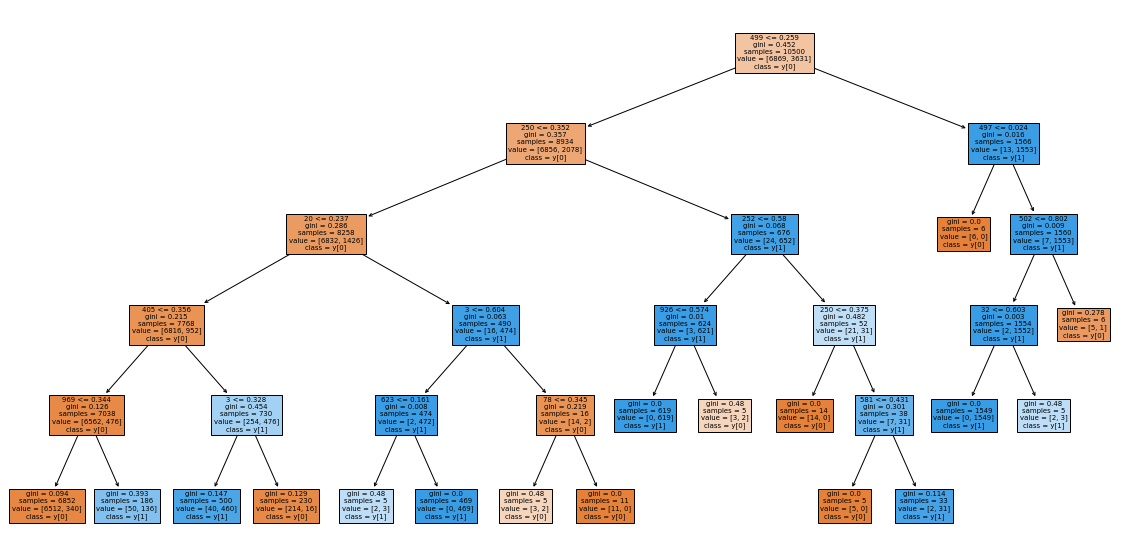

In [26]:
# Creating the decision tree classifier with pruning
pruned_dtree = DecisionTreeClassifier(max_depth=5, min_samples_leaf=5, min_samples_split=10, random_state=42)

# Fitting the model
pruned_dtree.fit(X_train, y_train)

# Making predictions
predictions = pruned_dtree.predict(X_test)

# Evaluating the model
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))
print(f"Accuracy: {accuracy_score(y_test, predictions) * 100:.2f}%")

# Plotting the pruned decision tree
plt.figure(figsize=(20,10))
plot_tree(pruned_dtree, filled=True, feature_names=column_names, class_names=True)
plt.show()

### Bagging regression tree

In [ ]:
from sklearn.ensemble import BaggingClassifier

# Creating a decision tree regressor as the base estimator
bagging_classifier = pruned_dtree

# Creating the bagging regressor
bagging_classifier = BaggingClassifier(base_estimator=base_regressor,
                                     n_estimators=100, # Number of trees
                                     random_state=42)

# Fit the model on training data
bagging_classifier.fit(X_train, y_train)

# Making predictions
y_pred = bagging_classifier.predict(X_test)

In [34]:
# Generating the confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

print(classification_report(y_test, y_pred))
print(f"Accuracy: {accuracy_score(y_test, y_pred) * 100:.2f}%")

Confusion Matrix:
[[2886   37]
 [ 192 1385]]
              precision    recall  f1-score   support

           1       0.94      0.99      0.96      2923
           2       0.97      0.88      0.92      1577

    accuracy                           0.95      4500
   macro avg       0.96      0.93      0.94      4500
weighted avg       0.95      0.95      0.95      4500

Accuracy: 94.91%


Based on the results above, we can get that using bagging method can improve the performance of pruned decision tree slightly.

### 4.2 Random Forest



In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Range of 'n_estimators' to explore
n_estimators_range = range(1, 101)  # 1 to 100 trees

# Lists to store results
test_errors = []

for n in n_estimators_range:
    # Create and fit the Random Forest model
    rf = RandomForestClassifier(n_estimators=n, random_state=42)
    rf.fit(X_train, y_train)

    # Predict on test data
    y_pred = rf.predict(X_test)

    # Calculate test error
    test_error = 1 - accuracy_score(y_test, y_pred)
    test_errors.append(test_error)

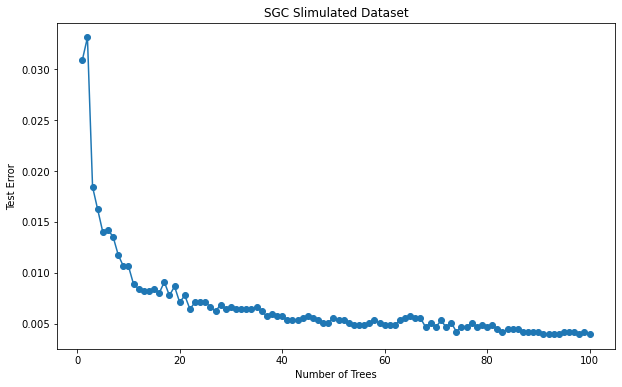

In [36]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(n_estimators_range, test_errors, marker='o')
plt.title('SGC Slimulated Dataset')
plt.xlabel('Number of Trees')
plt.ylabel('Test Error')
plt.show()

### Variable importance

In [ ]:
# Train the Random Forest model
rf = RandomForestClassifier(n_estimators=90, random_state=42)
rf.fit(X_train, y_train)

# Get feature importances
importances = rf.feature_importances_
std_devs = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)

indices = np.argsort(importances)[::-1]


top_n = 20
top_indices = indices[:top_n]
top_importances = importances[top_indices]
top_std_devs = std_devs[top_indices]

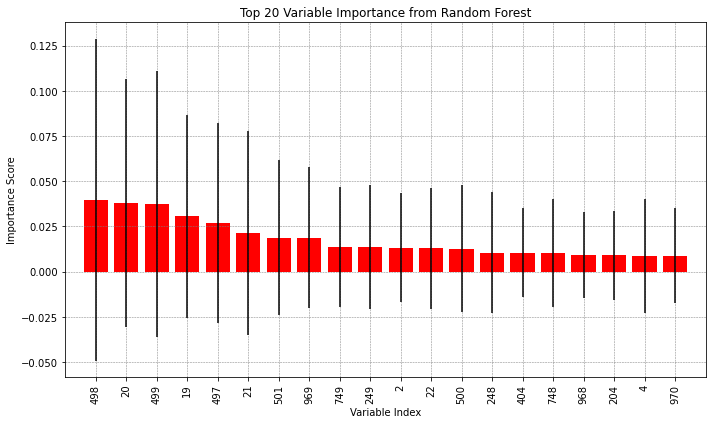

In [42]:
plt.figure(figsize=(10, 6))
plt.title("Top 20 Variable Importance from Random Forest")
plt.bar(range(top_n), top_importances, color="r", yerr=top_std_devs, align="center")
plt.xticks(range(top_n), top_indices, rotation=90)
plt.xlim([-1, top_n])
plt.xlabel('Variable Index')
plt.ylabel('Importance Score')
plt.grid(True, linestyle='--', color='grey', linewidth=0.5)  
plt.tight_layout() 
plt.show()

Here is the updated plot showing the importance scores for the top 20 variables from the Random Forest model. Each bar represents the importance of a variable, with the variable index on the x-axis and the importance score on the y-axis. The error bars indicate the standard deviation of the importance scores across the trees in the forest.​

In [43]:
# Making predictions
y_pred = rf.predict(X_test)

# Generating the confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

print(classification_report(y_test, y_pred))
print(f"Accuracy: {accuracy_score(y_test, y_pred) * 100:.2f}%")

Confusion Matrix:
[[2914    9]
 [  10 1567]]
              precision    recall  f1-score   support

           1       1.00      1.00      1.00      2923
           2       0.99      0.99      0.99      1577

    accuracy                           1.00      4500
   macro avg       1.00      1.00      1.00      4500
weighted avg       1.00      1.00      1.00      4500

Accuracy: 99.58%


The confusion matrix shows that there are very few false positives and false negatives (9 and 10 respectively out of 4500 predictions). This suggests that the model has a strong ability to distinguish between the classes.